In [1]:
! python --version

Python 3.10.14


In [2]:
%%capture
! pip install --upgrade pip
! pip install timm
! pip install torch
! pip install pillow
! pip install ipywidgets
! pip uninstall numpy -y
! pip install "numpy<2.0"
! pip install opencv-python
! pip install scikit-learn
! pip install scipy
! pip install matplotlib
! pip install torchinfo

## Fine-tuning the Resnet 34 model with our bird species dataset

Using PyTorch, we run a fine-tuning model training on the Resnet 34 model with our bird species dataset. The model is trained on the training dataset and validated on the test dataset. For this notebook, we"re running the training against a smaller subset of 50 bird species. With trial and error, I"ve found that an epoch setting or 8, batch size of 32, and a learning rate of 0.001 works well for this version dataset. When doing this for real, it would be best to run the training against the full dataset.


In [3]:
import torch
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import time
import os

start = time.time()

train_folder = "../kaggle_data/bird-fifty/train"
test_folder = "../kaggle_data/bird-fifty/test"

num_of_classes = len(os.listdir(train_folder))

model_no_fc_ready_to_fine_tune = timm.create_model("resnet34d.ra2_in1k", pretrained=True, num_classes=num_of_classes)
resnet_model = model_no_fc_ready_to_fine_tune

data_config = resolve_data_config({}, model=resnet_model)
transform = create_transform(**data_config)
train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001)

num_epochs = 8
training_start = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    training_loss = running_loss / len(train_loader)
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Training Loss: {round(training_loss, 5)}")
    
    train_accuracy = 100 * (correct / total)
    print(f"Training Accuracy: {round(train_accuracy, 5)}%")

    # Evaluate on test set
    resnet_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    test_loss = running_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {round(test_loss, 5)}")
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {round(test_accuracy, 5)}%")
    
    epoch_end = time.time()
    elapsed_time = epoch_end - epoch_start
    
    print(f"Epoch ({epoch+1}/{num_epochs}) time: {elapsed_time}")
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    
training_end = time.time()
elapsed_time = training_end - training_start

elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print(f"Total training time: {elapsed_time}")

Using device: mps

Epoch [1/8], Training Loss: 0.77757
Training Accuracy: 81.27793%
Epoch [1/8], Test Loss: 0.1514
Test Accuracy: 96.47059%
Epoch (1/8) time: 53.37177133560181

Epoch [2/8], Training Loss: 0.20813
Training Accuracy: 94.45585%
Epoch [2/8], Test Loss: 0.09545
Test Accuracy: 96.86275%
Epoch (2/8) time: 53.43459677696228

Epoch [3/8], Training Loss: 0.12034
Training Accuracy: 96.73874%
Epoch [3/8], Test Loss: 0.25417
Test Accuracy: 94.11765%
Epoch (3/8) time: 54.58634901046753

Epoch [4/8], Training Loss: 0.09209
Training Accuracy: 97.46346%
Epoch [4/8], Test Loss: 0.09418
Test Accuracy: 98.03922%
Epoch (4/8) time: 54.978667974472046

Epoch [5/8], Training Loss: 0.08802
Training Accuracy: 97.3306%
Epoch [5/8], Test Loss: 0.13058
Test Accuracy: 96.47059%
Epoch (5/8) time: 53.4250271320343

Epoch [6/8], Training Loss: 0.08241
Training Accuracy: 97.57217%
Epoch [6/8], Test Loss: 0.15401
Test Accuracy: 95.68627%
Epoch (6/8) time: 52.13827896118164

Epoch [7/8], Training Loss: 0

In [16]:
from torchinfo import summary

summary(resnet_model, input_size=(1, 3, 224, 224))  # Batch size of 1

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 512]                  --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU: 2-3                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └

In [17]:
# Remove the classification head, because we just need the output of the embedding model, and not the classification head
resnet_model.reset_classifier(0)  # save model with the classification head, remove this later after loading

In [18]:
from datetime import datetime

model_path = f"resnet34d.ra2_in1k_fine_tune_{num_of_classes}_classes_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pth"
torch.save(resnet_model.state_dict(), model_path, )

end = time.time()

In [19]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_(embedding1, embedding2):
    """
    Create a cosine similarity function that takes two embeddings and returns the cosine similarity between them.
    """    
    embedding1 = np.array(embedding1).reshape(1, -1)
    embedding2 = np.array(embedding2).reshape(1, -1)
    return cosine_similarity(embedding1, embedding2)[0][0]

def generate_embedding(image_path, model):
    """
    Generate embeddings for the input image.
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=resnet_model.default_cfg["mean"],
            std=resnet_model.default_cfg["std"]),
    ])

    image = Image.open(image_path)
    input_tensor = transform(image.convert("RGB")).unsqueeze(0).to(device)
    
    resnet_model.to(device)
    resnet_model.eval()
    
    with torch.no_grad():
        embedding = model(input_tensor)
    
    embedding = embedding.cpu().numpy().flatten()

    return embedding


In [20]:
# similar/same birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/5.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.7961037158966064



In [21]:
# dissimilar/different birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/BLUE THROATED TOUCANET/1.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.29630735516548157



In [22]:
# dissimilar/different birds
embedding1 = generate_embedding("../kaggle_data/bird-fifty/test/CEDAR WAXWING/4.jpg", resnet_model)
embedding2 = generate_embedding("../kaggle_data/bird-fifty/test/GLOSSY IBIS/1.jpg", resnet_model)

similarity = cosine_similarity_(embedding1, embedding2)
print(f"Cosine Similarity of is {similarity}\n")

Cosine Similarity of is 0.26946285367012024



### Comments about using pre-trained model to generate embeddings
Now that we have fine-tuned our embedding model against our bird species dataset, we can then use it to generate embeddings for our bird species images. This is done by passing the images through the model and extracting the embeddings from the last layer of the model. Because we have removed the classification head, our model now just spits out the embeddings of the image we pass in. 

So now (compared to just using the pre-trained model) the same bird species will have embeddings that are closer together and embeddings of different bird species are now quite far apart. This is because the model has been fine-tuned to recognise the specific features of the bird species in our dataset.

For example, in the similar case we get a score of `0.79369`, while the dissimilar image case gets a score of `0.33488` and `0.31218`. This is a significant difference compared to using the pre-trained model, and shows that this new fine-tuned model has learned to differentiate between the two images better.

In [23]:
# get all embeddings of images in the ../data/profiles folder
import os
import numpy as np

profiles_dir = "../kaggle_data/bird-fifty/valid/"

def get_all_embeddings(folder_path, embedding_model):
    embeddings = []
    image_paths = []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file == "1.jpg":
                image_path = os.path.join(root, file)
                embedding = generate_embedding(image_path, embedding_model)
                embeddings.append(embedding)
                image_paths.append(image_path)

    return np.array(embeddings), image_paths

all_embeddings = get_all_embeddings(profiles_dir, resnet_model)

print(f"Total of {len(all_embeddings[0])} bird species.")


Total of 51 bird species.


In [24]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

def distance_metric(embedding1, embedding2, metric="cosine"):
  embedding1 = np.array(embedding1).reshape(1, -1)
  embedding2 = np.array(embedding2).reshape(1, -1)
  if metric == "cosine":
    return cosine_similarity(embedding1, embedding2)[0][0]
  elif metric == "euclidean":
    return euclidean_distances(embedding1, embedding2)[0][0]

def find_similarities(image_1):
    
    image_1_embedding = generate_embedding(image_1, resnet_model)

    similarities = []
    metric="cosine"
    for i, embedding in enumerate(all_embeddings[0]):
        similarity = distance_metric(image_1_embedding, embedding, metric=metric)
        similarities.append({"image_1": image_1, "image_2": all_embeddings[1][i], "similarity": similarity})

    if metric == "cosine":
        similarities = sorted(similarities, key=lambda x: x["similarity"], reverse=True)
    else:
        similarities = sorted(similarities, key=lambda x: x["similarity"])

    # print(len(similarities))
    
    return similarities

similarities = find_similarities("../kaggle_data/bird-fifty/test/AFRICAN PYGMY GOOSE/4.jpg")

In [25]:
from matplotlib import pyplot as plt
from matplotlib import image as mp_img

def display_img(image_path, index, rows=1, columns=2, text=""):
    plt.subplot(rows, columns, index)
    img = mp_img.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{image_path.split('/')[-2]}/{image_path.split('/')[-1]}")
    plt.text(0.5, -0.1, text, ha='center', transform=plt.gca().transAxes)
    
    
def display_similarities(image_1, top_k=6):
    plt.figure(figsize=(4, 5))
    
    similarities = find_similarities(image_1)
    print(f"Unknown bird species: {image_1}")
    display_img(similarities[0]["image_1"], 1, rows=1, columns=1)
    plt.show()

    plt.figure(figsize=(15, 8))
    print(f"Most simiar bird species to {image_1}.")
    for i, similarity in enumerate(similarities[:top_k]):
        display_img(similarity["image_2"], i+1, rows=2, columns=int(top_k//2), text=f"Similarity: {similarity['similarity']:.5f}")
    
    plt.show()    

Unknown bird species: unknowns/4.jpg


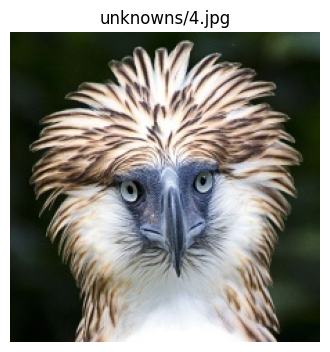

Most simiar bird species to unknowns/4.jpg.


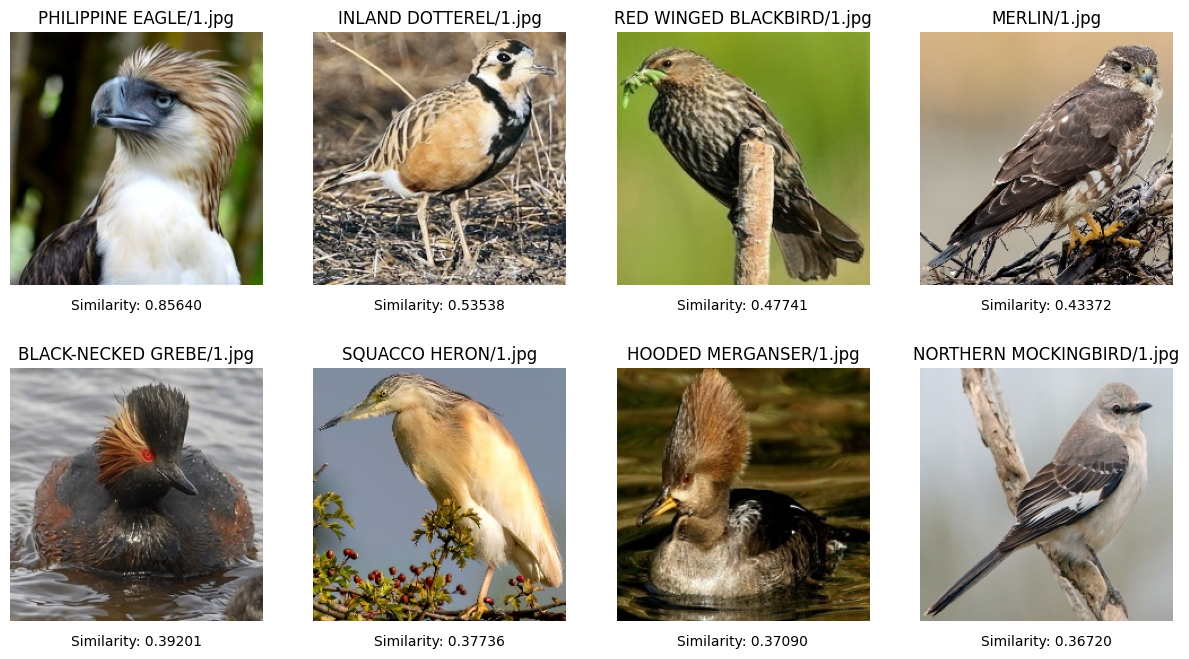

Unknown bird species: unknowns/5.jpg


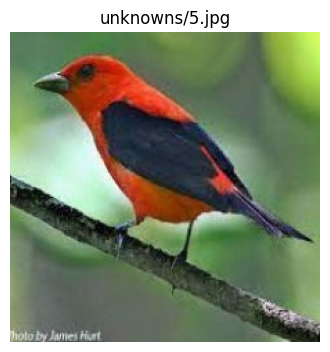

Most simiar bird species to unknowns/5.jpg.


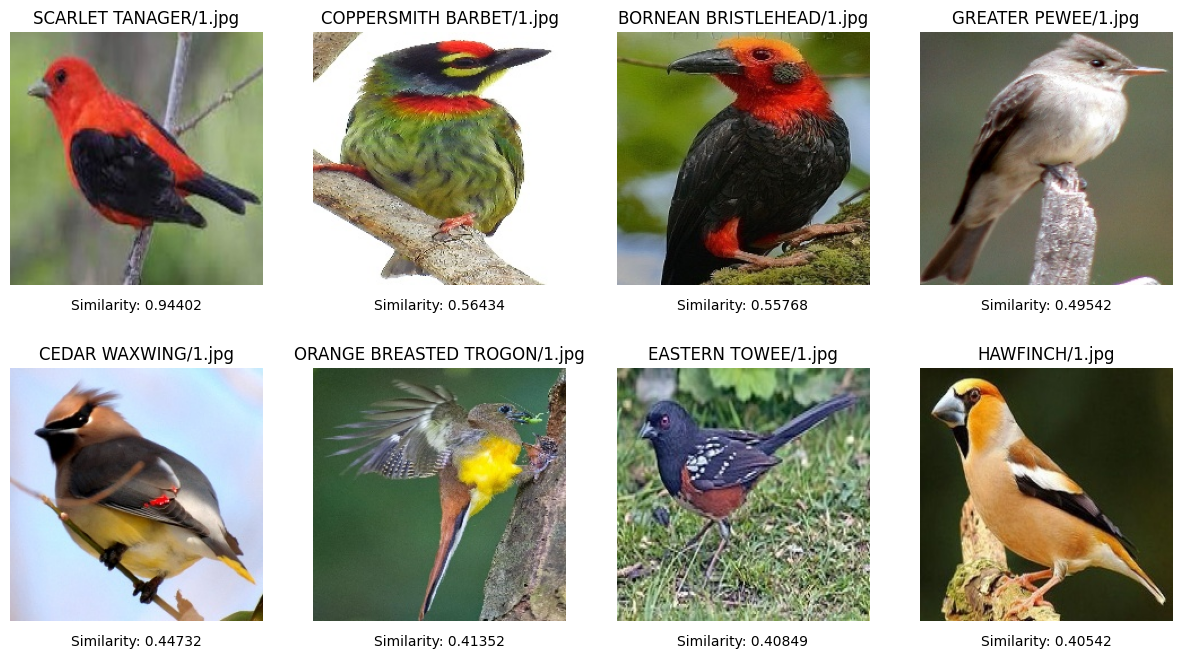

Unknown bird species: unknowns/2.jpg


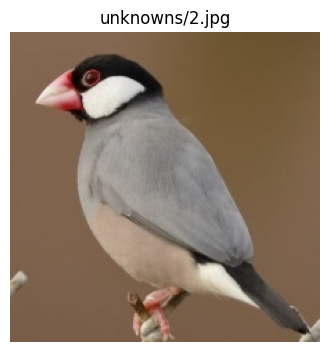

Most simiar bird species to unknowns/2.jpg.


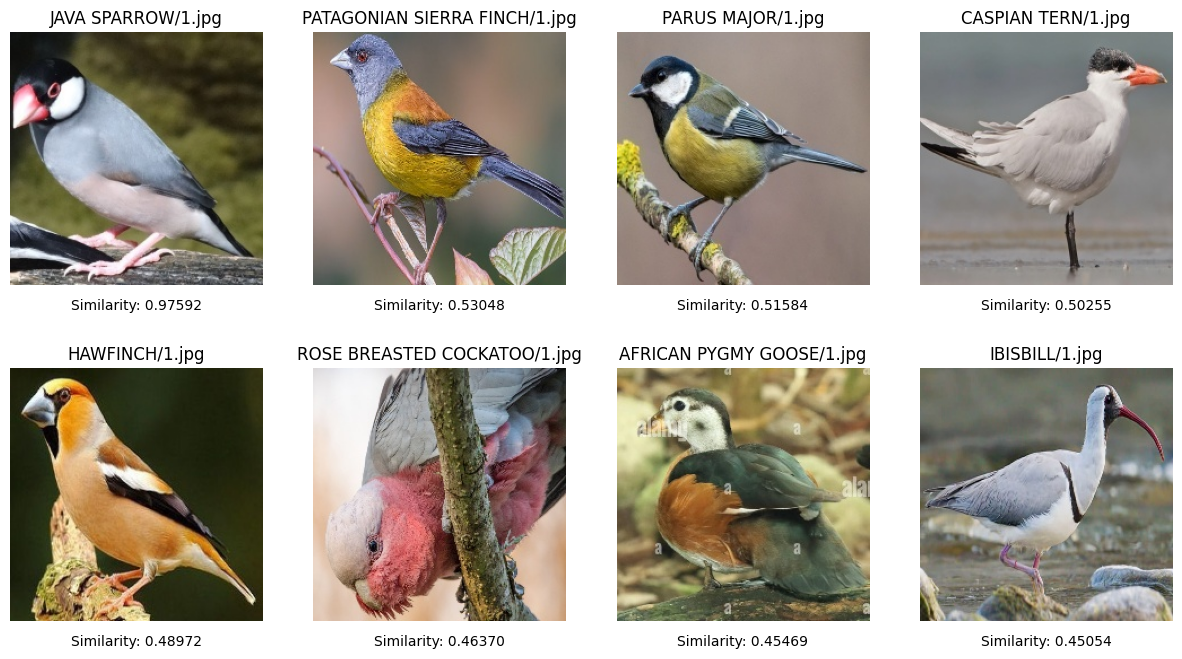

Unknown bird species: unknowns/3.jpg


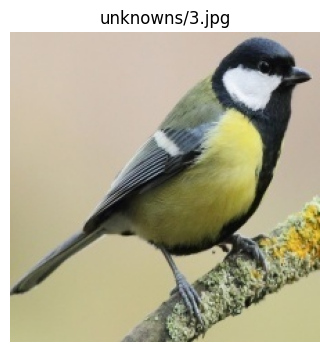

Most simiar bird species to unknowns/3.jpg.


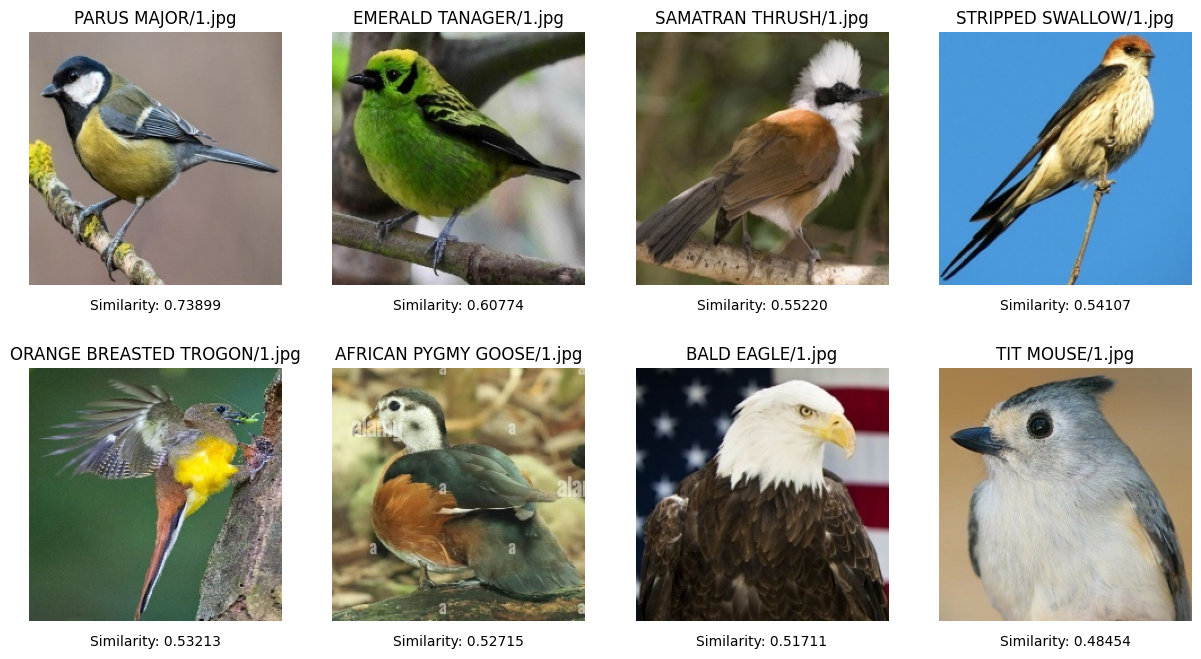

Unknown bird species: unknowns/1.jpg


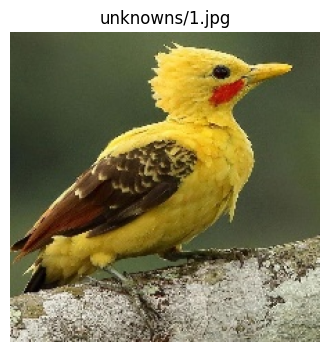

Most simiar bird species to unknowns/1.jpg.


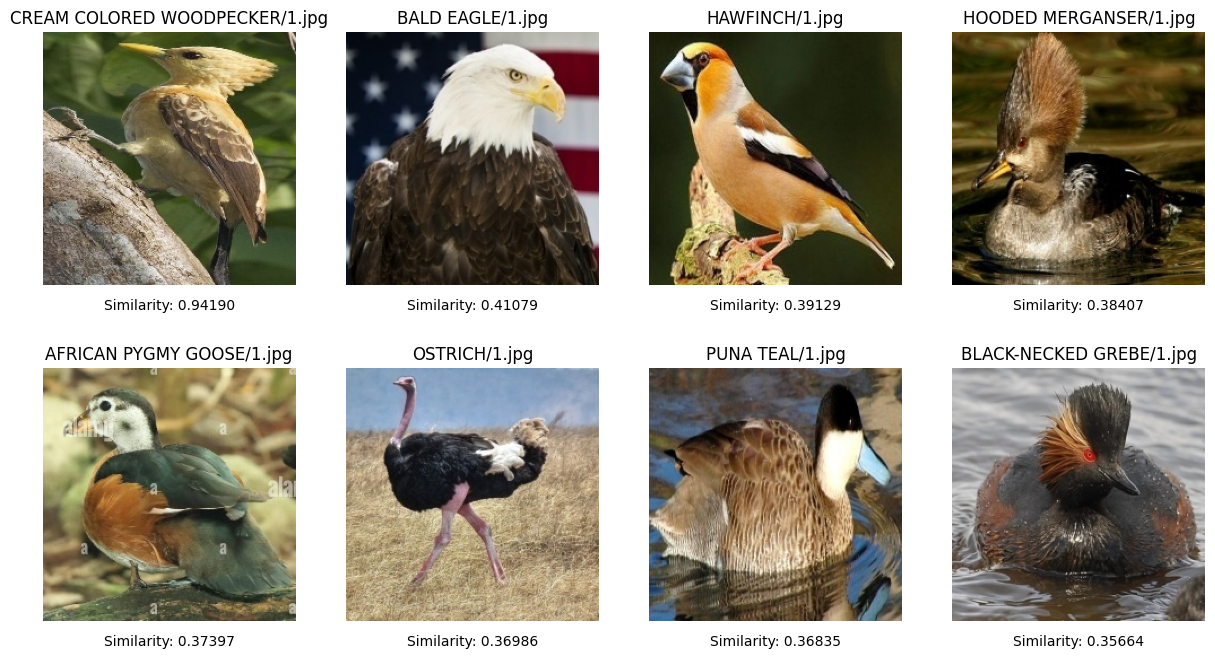

In [26]:
tracings_folder = "unknowns"

for file in os.listdir(tracings_folder):
    if file.endswith(".png") or file.endswith(".jpg"):
        display_similarities(os.path.join(tracings_folder, file), top_k=8)